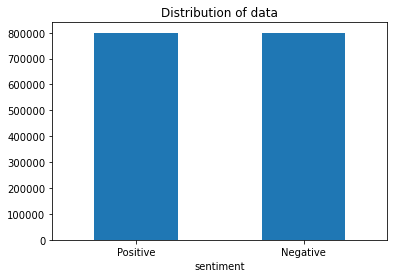

In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]

data = pd.read_csv(r"F:\College\Thesis\Thesis code\LargeSentimentTwitterData.csv", 
                   encoding = "ISO-8859-1", names = columns)

data = data[['sentiment','text']]
data['sentiment'] = data['sentiment'].replace(4,1)

ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Positive','Negative'], rotation=0)


tweet = list(data['text'])
sentiment = list(data['sentiment'])



In [3]:
def dataProcess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
  
    nonAlpha = "[^a-zA-Z0-9]"
    
    for tweet in textdata:
        tweet = tweet.lower()   
        
        tweet = re.sub(nonAlpha, " ", tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText
            


In [4]:
import time
t = time.time()
processedtext = dataProcess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 84 seconds


Most Occuring Words Overall


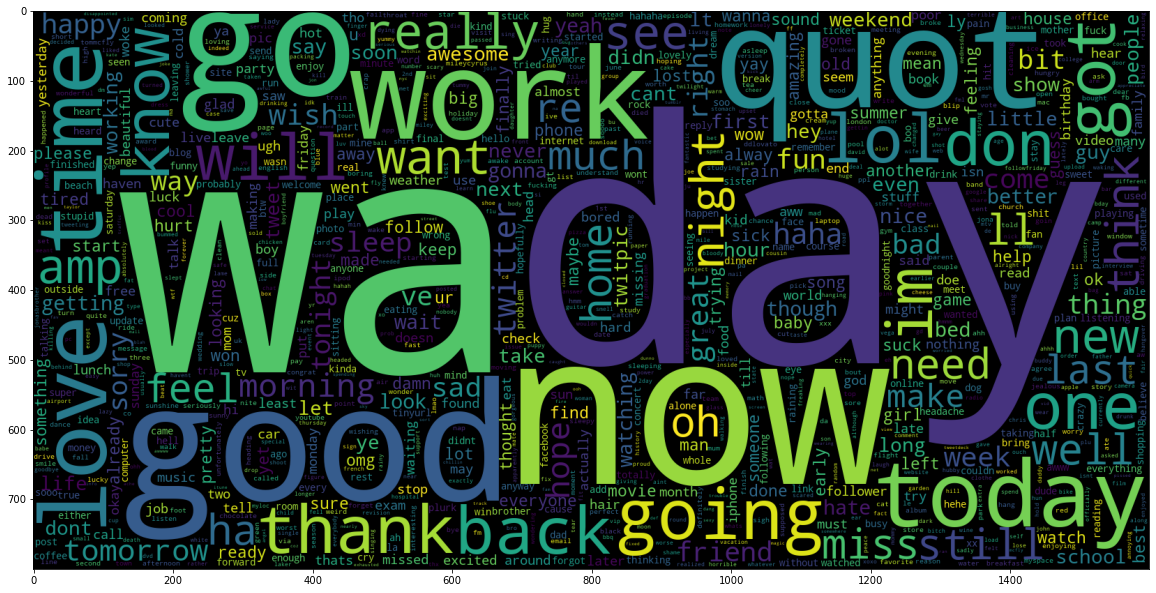

In [5]:
Words = processedtext
print(f'Most Occuring Words Overall')
plt.figure(figsize = (20,20))
wCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(Words))
plt.imshow(wCloud)

Most Occuring Negative Words


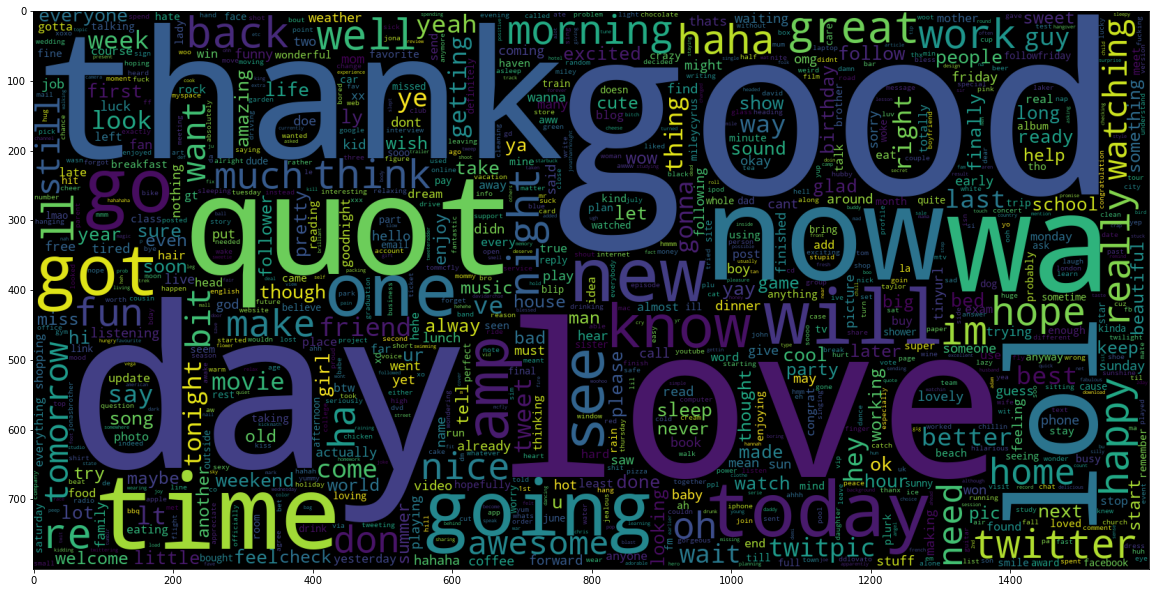

In [6]:
negaWords = processedtext[-800000:]
print(f'Most Occuring Negative Words')
plt.figure(figsize = (20,20))
negaCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negaWords))
plt.imshow(negaCloud)

Most Occuring Positive Words


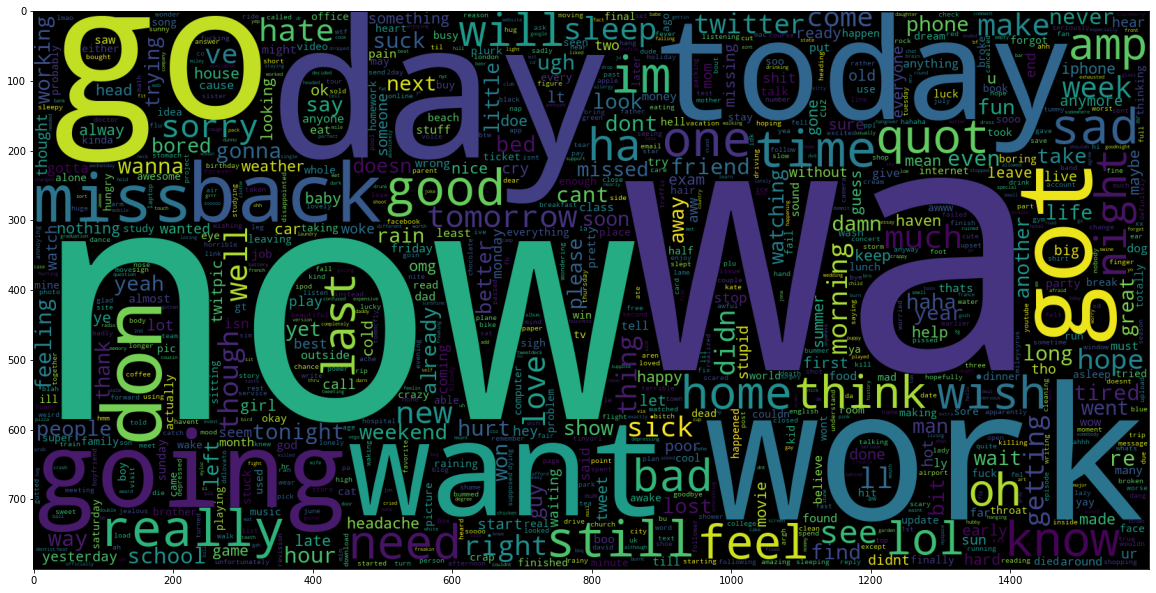

In [7]:
posiWords = processedtext[:800000]
print(f'Most Occuring Positive Words')
posiCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(posiWords))
plt.figure(figsize = (20,20))
plt.imshow(posiCloud)

In [8]:
xTrain, xTest, yTrain, yTest = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [9]:
vector = TfidfVectorizer(ngram_range = (1,2), max_features = 500000)
vector.fit(xTrain)
print(f'Vectoring Done')

xTrain = vector.transform(xTrain)
xTest = vector.transform(xTest)
print(f'Data Vectored.')

Vectoring Done
Data Vectored.


In [15]:
def evalModel(model):
    
    pred = model.predict(xTest)
    print(print(classification_report(yTest, pred)))
    


In [16]:
import time
t = time.time()

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(xTrain, yTrain)
evalModel(BNBmodel)

print(f'BernoulliNB Model Trained.')
print(f'Time Taken: {round(time.time()-t)} seconds')

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

None
BernoulliNB Model Trained.
Time Taken: 1 seconds


In [17]:
import time
t = time.time()

SVC = LinearSVC()
SVC.fit(xTrain, yTrain)
evalModel(SVC)

print(f'SVC Model Trained.')
print(f'Time Taken: {round(time.time()-t)} seconds')

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

None
SVC Model Trained.
Time Taken: 33 seconds


In [18]:
import time
t = time.time()

LogReg = LogisticRegression(C = 2, max_iter = 1500, n_jobs=-1)
LogReg.fit(xTrain, yTrain)
evalModel(LogReg)

print(f'Logistic Regression Model Trained.')
print(f'Time Taken: {round(time.time()-t)} seconds')

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

None
Logistic Regression Model Trained.
Time Taken: 150 seconds


In [19]:
file = open('dataVector.pickle', 'wb')
pickle.dump(vector, file)
print(f'Vector Saved')
file.close()

file = open('LogRegModel.pickle', 'wb')
pickle.dump(LogReg, file)
print(f'Logistic Regression Model Saved')
file.close()

Vector Saved
Logistic Regression Model Saved


In [28]:
def callModels():
    
    file = open('dataVector.pickle', 'rb')
    vectorFile = pickle.load(file)
    file.close()

    file = open('LogRegModel.pickle', 'rb')
    LogModel = pickle.load(file)
    file.close()
    
    return vectorFile, LogModel


def prediction(vec, model, text):

    predictData = vec.transform(text)
    sentiment = model.predict(predictData)
    
    predictions = []
    posCount = 0
    negCount = 0
    for text, pred in zip (text, sentiment):
        if pred == 0:
            negCount += 1
        elif pred == 1:
            posCount += 1
        predictions.append((text, pred))
    
    data = pd.DataFrame(predictions, columns = ['tweet','sentiment'])
    data = data.replace([0,1], ["Negative","Positive"])
    data.to_csv (r'F:\College\Thesis\Thesis code\export_dataframe.csv', index = False, header=True)
    
    
    return data, posCount, negCount
        

    
if __name__=="__main__":
    
    vector, logRegM = callModels()
    columns  = ["sentiment","text"]
    
    text = pd.read_csv(r"F:\College\Thesis\Thesis code\train200.csv", 
                       encoding = "ISO-8859-1", names = columns)
    
    text = text[['text']]
    text = list(text['text'])
    
    df, countP, countN = prediction(vector, logRegM, text)
    
        
    print(df.head(200)) 
    print('Total Positive Count: ', countP)
    print('Total Negative Count: ', countN)
    

                                                 tweet sentiment
0     @user when a father is dysfunctional and is s...  Negative
1    @user @user thanks for #lyft credit i can't us...  Negative
2                                  bihday your majesty  Positive
3    #model   i love u take with u all the time in ...  Positive
4               factsguide: society now    #motivation  Positive
..                                                 ...       ...
195  does #magnettherapy really work?   #altwaystoh...  Positive
196                     sebbo has said it all!  @user   Positive
197  ÃÂ°ÃÅ¸ÃËÃÂÃÂ°ÃÅ¸ÃËÃÂÃÂ°ÃÅ¸ÃËÃ...  Positive
198  @user brilliant service at your kettering bran...  Positive
199  @user will be here for a screening. i will mis...  Negative

[200 rows x 2 columns]
Total Positive Count:  273
Total Negative Count:  127


In [ ]:
Test SetContains 400 labelled tweets. 
200 Positive 200 Negative.

Total Correct Predictions In Theory: 200 + 124 = 324.
    Model Accuracy = 83%
    83% of 400 = 332
    Total Potential Correct Predictions = 324
    324 = 81% of 400
    332 - 324 = 8
    Drop of 2%
    
    
    truePos + trueNEg / truePos + trueNeg + falspos + false
    168 + 164 / 168 + 164 + 36 +32

In [ ]:
predictions = []
    posCount = 0
    negCount = 0
    for text, pred in zip (text, sentiment):
        if pred == 0:
            negCount += 1
        elif pred == 1:
            posCount += 1
        predictions.append((text, pred))
    
    data = pd.DataFrame(predictions, columns = ['tweet','sentiment'])
    data = data.replace([0,1], ["Negative","Positive"])
    
    return data, posCount, negCount